<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Space Shuttle Reentry Using OptimalControl.jl
</div>

<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Space Shuttle Reentry Problem:* We aim find the optimal trajectory of a space shuttle reentry while minimizing the angle of attack at the terminal point.
The problem is inspired from Chapter 6 of: [Practical Methods for Optimal Control and Estimation Using Nonlinear Programming, Second Edition](https://epubs.siam.org/doi/book/10.1137/1.9780898718577).                             
We solve the problem using the [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) package in Julia.

1. [Solving with OptimalControl](#oc)
2. [Comparing with JuMP](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with OptimalControl <a id='oc'></a>

1. Import the problem

In [3]:
using OptimalControl
using NLPModelsIpopt
using MKL
include("../Problems/OptimalControl/space_Shuttle_OC.jl")
nh = 503
SpaceShuttleOC = space_Shuttle_OC()


The (autonomous) optimal control problem is given by:

    w = 203000.0
    g₀ = 32.174
    m = w / g₀
    ρ₀ = 0.002378
    hᵣ = 23800.0
    Rₑ = 2.09029e7
    μ = 1.4076539e16
    S = 2690.0
    a₀ = -0.20704
    a₁ = 0.029244
    b₀ = 0.07854
    b₁ = -0.0061592
    b₂ = 0.000621408
    c₀ = 1.0672181
    c₁ = -0.019213774
    c₂ = 0.00021286289
    c₃ = -1.0117249e-6
    h_s = 2.6
    ϕ_s = deg2rad(0)
    θ_s = deg2rad(0)
    v_s = 2.56
    γ_s = deg2rad(-1)
    ψ_s = deg2rad(90)
    α_s = deg2rad(0)
    β_s = deg2rad(0)
    t_s = 1.0
    h_t = 0.8
    v_t = 0.25
    γ_t = deg2rad(-5)
    t0 = 0.0
    tf ∈ R, variable
    t ∈ [t0, tf], time
    x ∈ R⁶, state
    u ∈ R², control
    scaled_h = x₁
    ϕ = x₂
    θ = x₃
    scaled_v = x₄
    γ = x₅
    ψ = x₆
    α = u₁
    β = u₂
    1800 ≤ tf ≤ 2200, tf_con
    scaled_h(t) ≥ 0, scaled_h_con
    deg2rad(-89) ≤ θ(t) ≤ deg2rad(89), θ_con
    scaled_v(t) ≥ 0.0001, scaled_v_con
    deg2rad(-89) ≤ γ(t) ≤ deg2rad(89), γ_con
    deg2rad(-8

2. Initial guess

In [4]:
init = space_Shuttle_init(;nh=nh-1)

(time = LinRange{Float64}(0.0, 2008.0, 502), state = [[2.6, 0.0, 0.0, 2.56, -0.017453292519943295, 1.5707963267948966], [2.5964071856287423, 0.0, 0.0, 2.555389221556886, -0.0175926401648131, 1.5707963267948966], [2.5928143712574854, 0.0, 0.0, 2.5507784431137726, -0.01773198780968291, 1.5707963267948966], [2.5892215568862276, 0.0, 0.0, 2.5461676646706586, -0.017871335454552714, 1.5707963267948966], [2.58562874251497, 0.0, 0.0, 2.5415568862275446, -0.018010683099422525, 1.5707963267948966], [2.582035928143713, 0.0, 0.0, 2.536946107784431, -0.018150030744292327, 1.5707963267948966], [2.578443113772455, 0.0, 0.0, 2.5323353293413176, -0.01828937838916214, 1.5707963267948966], [2.5748502994011973, 0.0, 0.0, 2.5277245508982036, -0.018428726034031943, 1.5707963267948963], [2.5712574850299403, 0.0, 0.0, 2.52311377245509, -0.018568073678901748, 1.5707963267948966], [2.5676646706586825, 0.0, 0.0, 2.518502994011976, -0.018707421323771557, 1.5707963267948966]  …  [0.8323353293413174, 0.0, 0.0, 0.29

3. solving the problem

In [5]:
import HSL_jll
sol = OptimalControl.solve(SpaceShuttleOC,
                            grid_size = nh-1,
                            init=init,
                            max_iter = 1000,
                            linear_solver="ma57",hsllib=HSL_jll.libhsl_path,
                            tol = 1e-8,
                            constr_viol_tol = 1e-6
                            #output_file="rocketOC.out",
                            #display=false,
                            )

Method = 

4. Showing the results

In [12]:
rad2deg(sol.objective)

0.0002833794663362142

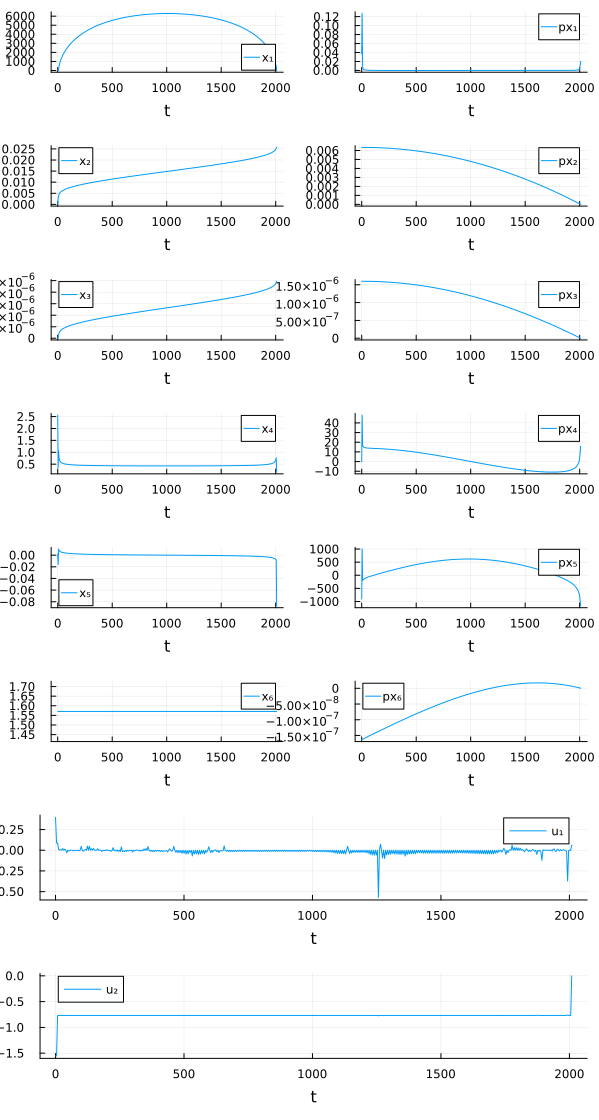

In [13]:
plot(sol)

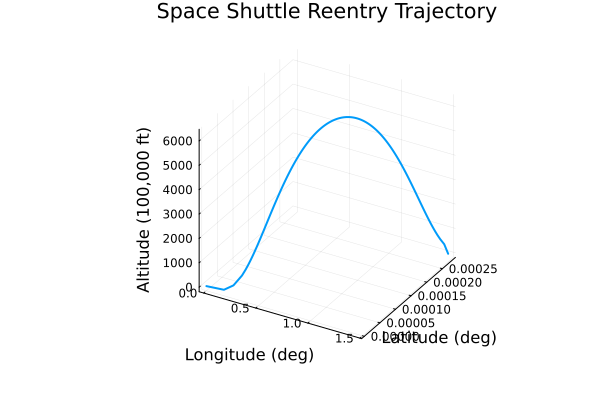

In [14]:
using JuMP
Δt = ones(n)*(tf/(n-1))
ts = cumsum([0; value.(Δt)])[1:end-1]
x = [sol.state(t) for t in ts]
scaled_h = [x[i][1] for i in 1:length(x)]
ϕ = [x[i][2] for i in 1:length(x)]
θ = [x[i][3] for i in 1:length(x)]
plot(
    rad2deg.(ϕ),
    rad2deg.(θ),
    scaled_h;
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

## 2. Comparing with JuMP <a id='comp'></a>

In [5]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/space_Shuttle_JMP.jl")
SpaceShuttleJMP = space_Shuttle_JMP("trapezoidal";nh=503)
set_optimizer(SpaceShuttleJMP,Ipopt.Optimizer)
set_attribute(SpaceShuttleJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(SpaceShuttleJMP, "linear_solver", "ma57")
set_attribute(SpaceShuttleJMP, "mu_strategy", "adaptive")
optimize!(SpaceShuttleJMP) 



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    33141
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   179214

Total number of variables............................:     4526
                     variables with only lower bounds:     1006
                variables with lower and upper bounds:     2514
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3021
Total number of inequality constrai

Final latitude θ = 34.14°


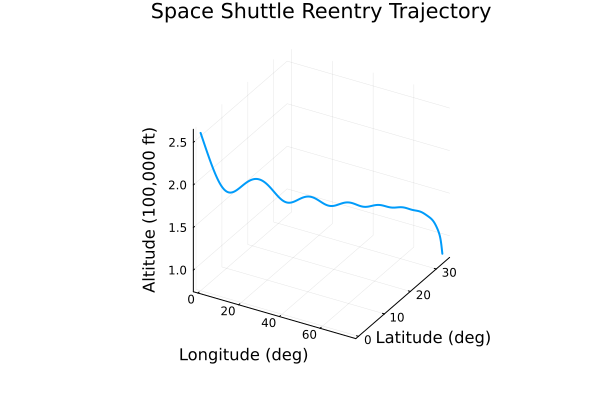

In [4]:
using Plots
println(
    "Final latitude θ = ",
    round(objective_value(SpaceShuttleJMP) |> rad2deg; digits = 2),
    "°",
)
scaled_h = SpaceShuttleJMP[:scaled_h]
ϕ = SpaceShuttleJMP[:ϕ]
θ = SpaceShuttleJMP[:θ]
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

----------------

# Contraintes de boites  et non linéaire

In [6]:
list_of_constraint_types(SpaceShuttleJMP)

4-element Vector{Tuple{Type, Type}}:
 (NonlinearExpr, MathOptInterface.EqualTo{Float64})
 (AffExpr, MathOptInterface.EqualTo{Float64})
 (VariableRef, MathOptInterface.GreaterThan{Float64})
 (VariableRef, MathOptInterface.LessThan{Float64})

In [7]:
using MathOptInterface
cb_JMP = length(all_constraints(SpaceShuttleJMP, VariableRef, MathOptInterface.GreaterThan{Float64})) + length(all_constraints(SpaceShuttleJMP, VariableRef, MathOptInterface.LessThan{Float64}));
println("Nombre de contraintes de boite pour JuMP : ", cb_JMP)
cnl_JMP = length(all_constraints(SpaceShuttleJMP, NonlinearExpr, MathOptInterface.EqualTo{Float64})) + length(all_constraints(SpaceShuttleJMP, AffExpr, MathOptInterface.EqualTo{Float64}));


output = read("rocketOC.out", String)
ub_lb = parse(Float64,split(split(output, "                variables with lower and upper bounds:")[2], "\n")[1])
ub = parse(Float64,split(split(output, "                     variables with only upper bounds:")[2], "\n")[1])
lb = parse(Float64,split(split(output, "                     variables with only lower bounds:")[2], "\n")[1])
println("Nombre de contraintes de boite pour OC : ", Int64(ub_lb*2+ub+lb))
eq = parse(Float64,split(split(output, "Total number of equality constraints.................:")[2], "\n")[1])
ineq = parse(Float64,split(split(output, "Total number of inequality constraints...............:")[2], "\n")[1])
println("Nombre de contraintes non linéaires pour JuMP : ", cnl_JMP)
println("Nombre de contraintes non linéaires pour OC : ", Int64(eq+ineq))


Nombre de contraintes de boite pour JuMP : 6034
Nombre de contraintes de boite pour OC : 1010
Nombre de contraintes non linéaires pour JuMP : 3021
Nombre de contraintes non linéaires pour OC : 609


----


# Initial guess

In [ ]:
start_value()

In [6]:
import Interpolations
n = 503
## Initial conditions
h_s = 2.6          # altitude (ft) / 1e5
ϕ_s = deg2rad(0)   # longitude (rad)
θ_s = deg2rad(0)   # latitude (rad)
v_s = 2.56         # velocity (ft/sec) / 1e4
γ_s = deg2rad(-1)  # flight path angle (rad)
ψ_s = deg2rad(90)  # azimuth (rad)
α_s = deg2rad(0)   # angle of attack (rad)
β_s = deg2rad(0)   # bank angle (rad)
t_s = 1.00         # time step (sec)
## Final conditions
h_t = 0.8          # altitude (ft) / 1e5
v_t = 0.25         # velocity (ft/sec) / 1e4
γ_t = deg2rad(-5)  # flight path angle (rad)

x_s = [h_s, ϕ_s, θ_s, v_s, γ_s, ψ_s, α_s, β_s,t_s]
x_t = [h_t, ϕ_s, θ_s, v_t, γ_t, ψ_s, α_s, β_s,t_s]
interp_linear = Interpolations.LinearInterpolation([1, n], [x_s, x_t])
initial_guess = mapreduce(transpose, vcat, interp_linear.(1:n))

503×9 Matrix{Float64}:
 2.6       0.0  0.0  2.56      -0.0174533  1.5708  0.0  0.0  1.0
 2.59641   0.0  0.0  2.5554    -0.0175924  1.5708  0.0  0.0  1.0
 2.59283   0.0  0.0  2.5508    -0.0177314  1.5708  0.0  0.0  1.0
 2.58924   0.0  0.0  2.5462    -0.0178705  1.5708  0.0  0.0  1.0
 2.58566   0.0  0.0  2.54159   -0.0180096  1.5708  0.0  0.0  1.0
 2.58207   0.0  0.0  2.53699   -0.0181486  1.5708  0.0  0.0  1.0
 2.57849   0.0  0.0  2.53239   -0.0182877  1.5708  0.0  0.0  1.0
 2.5749    0.0  0.0  2.52779   -0.0184268  1.5708  0.0  0.0  1.0
 2.57131   0.0  0.0  2.52319   -0.0185659  1.5708  0.0  0.0  1.0
 2.56773   0.0  0.0  2.51859   -0.0187049  1.5708  0.0  0.0  1.0
 ⋮                                         ⋮                 
 0.828685  0.0  0.0  0.286813  -0.0861539  1.5708  0.0  0.0  1.0
 0.8251    0.0  0.0  0.282211  -0.086293   1.5708  0.0  0.0  1.0
 0.821514  0.0  0.0  0.27761   -0.086432   1.5708  0.0  0.0  1.0
 0.817928  0.0  0.0  0.273008  -0.0865711  1.5708  0.0  0.0  1.0
 0.81

In [5]:
function get_x0_ipopt(model)
    optimizer = Ipopt.Optimizer()
    MOI.copy_to(optimizer, model)
    primal_start = optimizer.variable_primal_start
    n_var = length(primal_start)
    x0 = zeros(n_var)
    for i in eachindex(x0)
        if isnothing(primal_start[i])
            lb = optimizer.variables.lower[i]
            ub = optimizer.variables.upper[i]
            x0[i] = clamp(0.0, lb, ub)
        else
            x0[i] = primal_start[i]
        end
    end
    return x0
end

get_x0_ipopt (generic function with 1 method)

In [7]:
9*503

4527

In [6]:
get_x0_ipopt(SpaceShuttleJMP)

4526-element Vector{Float64}:
 2.6
 2.596414342629482
 2.592828685258964
 2.5892430278884464
 2.5856573705179287
 2.5820717131474105
 2.5784860557768923
 2.5749003984063745
 2.5713147410358568
 2.567729083665339
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [51]:
[x for x in get_x0_ipopt(SpaceShuttleJMP)[7*n+1:n*8].-initial_guess[:,8] if x != 0]

Float64[]